## ==================== Libraries ====================

In [1]:
# Determinadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Procesamiento de imágenes
import cv2

In [2]:
# Algoritmo de evolución diferencial propio.
from differential_evolution import differential_algorithm

## <br><br><br><br>====================  Functions ====================

In [3]:
def orderPoints(points):
    ''' Regresa las coordenadas de los vértices de un polígono de 4 lados en el 
        orden: Arriba-Izquierda, Arriba-Derecha, Abajo-Derecha, Abajo-Izquierda.
        points: Coordenadas de los vértices de un polígono de 4 lados. '''
    
    # Puntos ordenados.
    ordered_points = np.zeros((4, 2), dtype = "float32")
    
    # Orden para saber cuáles son los puntos de arriba y de abajo del rectángulo.
    sort = np.argsort(points[:,1])
    top_sort = points[sort[:2]]
    bottom_sort = points[sort[2:]]
    
    # Arriba-Izquierda.
    ordered_points[0] = top_sort[np.argmin(top_sort[:,0])]
    # Arriba-Derecha
    ordered_points[1] = top_sort[np.argmax(top_sort[:,0])]
    # Abajo-Derecha
    ordered_points[2] = bottom_sort[np.argmax(bottom_sort[:,0])]
    # Abajo-Izquierda.
    ordered_points[3] = bottom_sort[np.argmin(bottom_sort[:,0])]

    return ordered_points

In [4]:
def rectangleImageTransform(img, points):
    ''' Regresa una imagen deformada según los contornos de un polígono de 4
        lados.
        img: Imagen.
        points: Coordenadas de los vértices de un polígono de 4 lados. '''
    
    # Obtener puntos ordenados del rectángulo.
    rect = orderPoints(points)
    
    # Desempaquetar puntos del rectángulo.
    tl, tr, br, bl = rect

    # Calcular el ancho de la nueva imagen (distancia entre coordenadas).
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Calcular la altura de la nueva imagen (distancia entre coordenadas).
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Dimensiones de la nueva imagen.
    new_img_dimension = np.array([[0, 0],
                                  [maxWidth - 1, 0],
                                  [maxWidth - 1, maxHeight - 1],
                                  [0, maxHeight - 1]], dtype = "float32")

    # Realizar la transformación.
    M = cv2.getPerspectiveTransform(rect, new_img_dimension)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    # Redimensionar imagen.
    warped = cv2.resize(warped, (800, 500))
    
    return warped

In [5]:
def cutMatrix(img):
    ''' Regresa una imagen de la matriz de colores recortada.
        img: Imagen. '''
    
    # Copiar imagen.
    img_copy = img.copy()
    
    # Sacar forma de la imagen.
    height, width, channels = img.shape
    
    # Obtener área de la imagen.
    img_area = height*width

    # Convertir a escala de grises.
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Obtener bordes.
    thresh = cv2.threshold(img_gray, 160, 200, cv2.THRESH_BINARY_INV)[1]
    
    # Obtener contornos.
    countours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # El mejor candidato.
    best_fig = []
    best_fig_area = 0
    
    # Restringir los rectángulos válidos
    for c in countours:
        # Obtener su área.
        area = cv2.contourArea(c)
        
        # Calcular perímetro del contorno.
        epsilon = 0.018*cv2.arcLength(c,True)
        
        # Encontrar figura aproximada.
        approx_fig = cv2.approxPolyDP(c,epsilon,True)
        
        if len(approx_fig) == 4 and area >= img_area*0.01:  
            if area > best_fig_area:
                best_fig = approx_fig
                best_fig_area = area
    
    # Convertir a np.array.
    best_fig = np.array(best_fig[:,0,:])
    
    warped_img = rectangleImageTransform(img_copy, best_fig)
    
#     # Mostrar imagen.
#     plt.figure()
#     plt.plot(best_fig[0,0], best_fig[0,1], marker='v', color="red")
#     plt.plot(best_fig[1,0], best_fig[1,1], marker='v', color="red")
#     plt.plot(best_fig[2,0], best_fig[2,1], marker='v', color="red")
#     plt.plot(best_fig[3,0], best_fig[3,1], marker='v', color="red")
#     plt.imshow(img_copy, cmap="gray")
#     plt.title("Original color checker image")
#     plt.show()
    
    return warped_img

In [6]:
def getMatrix(img, matrix_shape, width_shape=10, height_shape=10):  
    ''' Regresa una matriz con los colores que hay en la imagen con la matriz de colores.
        img: Imagen.
        matrix_shape: Dimensiones de la matriz.
        width_shape: Ancho de la selección de color.
        height_shape: Altura de la selección de color. '''
    
    # Matriz.
    m = np.zeros((matrix_shape[0]*matrix_shape[1],3), dtype='uint8')
    
    # Imagen para visualizar dónde se tomaron los colores.
    color_extraction_img = img.copy()
    
    # Iterador para la matriz.
    m_it = 0
    
    # Coordenadas de inicio.
    x, y = 50, 50
    
    for i in range(matrix_shape[0]):        
        # Aumentar en 'y'.
        yi = y + i*124
        for j in range(matrix_shape[1]):
            # Aumentar en 'x'.
            xi = x + j*135
            
            # Extraer región de color.
            color_region = img[yi: yi + height_shape, xi: xi + width_shape]

            # Obtener la mediana de la región del color.
            color_median = np.array([np.median(color_region[:,:,0]), np.median(color_region[:,:,1]), np.median(color_region[:,:,2])])
    
            # Poner en la matriz.
            m[m_it] = color_median
        
            # Marcar región del color extraído con negro.
            color_extraction_img[yi: yi + height_shape, xi: xi + width_shape] = 0
            
            # Aumentar iterador.
            m_it += 1
    
    # Mostrar imagen.
    plt.figure()
    plt.imshow(color_extraction_img, cmap="gray")
    plt.title("Color extraction points")
    plt.show()
    
    return m

In [7]:
def objective_function(P, X, Y):
    # La función objetivo simplemente toma la diferencia entre la matriz propuesta y la de control.
    m = np.reshape(P.copy(), (3,3))
    
    # Producto punto de 'Mo' con 'm'.
    proposed_Mc = np.matmul(X, m)
    
    # Se redondea para tener valores enteros y evitar problemas con los pixeles al tener valores flotantes.
    proposed_Mc = np.round(proposed_Mc)
    
    # Si los valores de la matriz sobrepasan los lìmites, simplemente se pone el lìmite.
    proposed_Mc = np.where(proposed_Mc > 255, 255, proposed_Mc)
    proposed_Mc = np.where(proposed_Mc < 0, 0, proposed_Mc)
    
    # Calcular la diferencia.
    rest = np.abs(np.subtract(Y, proposed_Mc))
    difference = np.sum(rest)
    
    return difference

In [8]:
def color_calibration(img, m):
    # Para calibrar la imagen se convierte la misma a un arreglo de (ancho*alto, 3) para poder aplicar el producto punto.
    height, width, nch = img.shape
    newImg = img.copy()
    newImg = np.reshape(newImg, (height * width, nch))
    
    dotProduct = np.matmul(newImg, m)
    dotProduct = np.where(dotProduct > 255, 255, dotProduct)
    dotProduct = np.where(dotProduct < 0, 0, dotProduct)
    
    return dotProduct.reshape(img.shape).astype(img.dtype)

## <br><br><br><br>====================  Main ====================

### Load color checker image (control matrix)

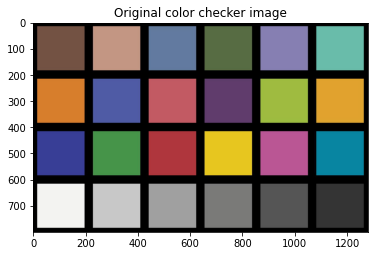

In [9]:
# Direcciones del dataset.
path = r'datasets/c.jpg'

# Leer documento .csv.
control_color_checker_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# Imagen a numpy array.
control_color_checker_img = np.asarray(control_color_checker_img)

# Mostrar imagen.
plt.figure()
plt.imshow(control_color_checker_img)
plt.title("Original color checker image")
plt.show()

### Load image to calibrate

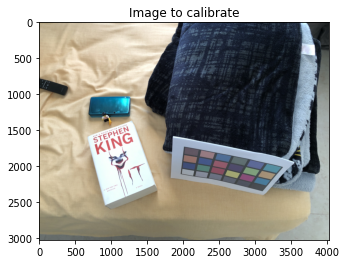

In [10]:
# Direcciones del dataset.
path = r'datasets/img_1.jpeg'

# Leer documento .csv.
image_to_calibrate = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# Imagen a numpy array.
image_to_calibrate = np.asarray(image_to_calibrate)

# Mostrar imagen.
plt.figure()
plt.imshow(image_to_calibrate)
plt.title("Image to calibrate")
plt.show()

### Cut matrices from the images

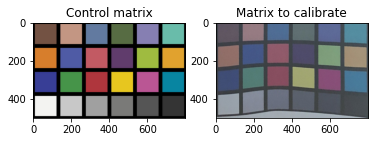

In [11]:
# Recortar matriz de control.
control_matrix_img = cutMatrix(control_color_checker_img)

# Recortar matriz a calibrar.
matrix_to_calibrate = cutMatrix(image_to_calibrate)

# Mostrar imagen.
plt.figure()
plt.subplot(1,2,1)
plt.imshow(control_matrix_img)
plt.title("Control matrix")
plt.subplot(1,2,2)
plt.imshow(matrix_to_calibrate)
plt.title("Matrix to calibrate")
plt.show()

### Get matrices

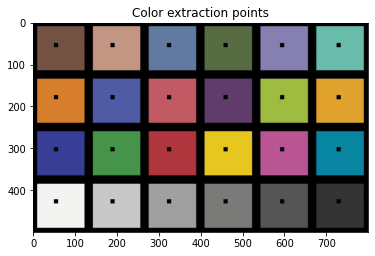

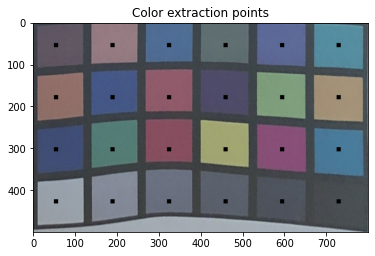

c = 
 [[115  82  67]
 [195 150 131]
 [ 98 122 160]
 [ 87 108  67]
 [134 127 178]
 [105 188 170]
 [215 126  44]
 [ 79  91 165]
 [194  90  99]
 [ 96  60 108]
 [159 187  64]
 [225 162  46]
 [ 56  62 150]
 [ 70 148  73]
 [175  54  61]
 [231 198  31]
 [186  86 148]
 [  8 133 161]
 [243 243 241]
 [200 200 200]
 [160 160 160]
 [122 122 120]
 [ 85  85  85]
 [ 52  52  52]] 


Mo = 
 [[ 96  85  97]
 [151 124 131]
 [ 80 109 149]
 [ 96 112 112]
 [ 93 106 151]
 [ 85 142 161]
 [145 110 104]
 [ 69  87 135]
 [144  91 107]
 [ 79  76 107]
 [127 158 123]
 [163 146 120]
 [ 64  77 117]
 [ 84 124 116]
 [136  77  95]
 [161 165 114]
 [136  79 120]
 [ 72 123 154]
 [152 161 170]
 [131 137 151]
 [105 111 127]
 [ 90  96 108]
 [ 79  83  94]
 [ 74  79  83]] 




In [12]:
# Dimensiones de la matriz (4x6).
matrix_shape = [4,6]

# Obtener matriz de control
c = getMatrix(control_matrix_img, matrix_shape)

# Obtener matriz a calibrar.
mo = getMatrix(matrix_to_calibrate, matrix_shape)

# Impresión de las matrices.
print('c = \n', c, '\n\n')
print('Mo = \n', mo, '\n\n')

### Set parameters

In [13]:
# Los bounds fueron elegidos luego de que en varias ocasiones nos percatamos de que los mejores resultados del differential evolution estuvieran dentro de ese rango, y de esta manera le facilitamos el trabajo al algoritmo.
min_limit, max_limit = -2, 2
bounds = [[min_limit,max_limit], [min_limit,max_limit], [min_limit,max_limit],
          [min_limit,max_limit], [min_limit,max_limit], [min_limit,max_limit],
          [min_limit,max_limit], [min_limit,max_limit], [min_limit,max_limit]] 

### Differential Evolution

In [14]:
# Variables generales.
iterations = 100
best_solution = [1000000000, [], 0]
worst_solution = [0, [], 0]
fitness_list = []

In [15]:
# Iteraciones del algoritmo de evolución diferncial.
for i in range(iterations):
    # Ejecución de Differential Evolution con poblacion de 30 y 1000 generaciones-
    res = differential_algorithm(objective_function, bounds, args=(mo,c), popsize=30, ngen=1000, cr=0.5)
    
    # Añadir a la lista.
    fitness_list.append(res['fun'])
    
    if res['fun'] < best_solution[0]:
        best_solution[0] = res['fun']
        best_solution[1] = res['P']
        best_solution[2] = i
    elif res['fun'] > worst_solution[0]:
        worst_solution[0] = res['fun']
        worst_solution[1] = res['P']
        worst_solution[2] = i

# Mostrar resultado.
print('====Mejor solución====')
print("-Fitness: " + str(best_solution[0]) + '\n' +
      '-Array: ' + str(best_solution[1]) + '\n' +
      '-Iteración: ' + str(best_solution[2]) + '\n')
      
print('====Peor solución====')
print("-Fitness: " + str(worst_solution[0]) + '\n' +
      '-Array: ' + str(worst_solution[1]) + '\n' +
      '-Iteración: ' + str(worst_solution[2]))

====Mejor solución====
-Fitness: 1284.0
-Array: [ 1.4795415  -0.14310687 -0.10365704  0.05656043  1.43313702 -1.10108836
 -0.20309449 -0.15275065  2.        ]
-Iteración: 48

====Peor solución====
-Fitness: 1295.0
-Array: [ 1.52736628 -0.19708273 -0.05696325 -0.00907988  1.48797462 -1.12985043
 -0.18696504 -0.16760418  1.9759202 ]
-Iteración: 45


In [16]:
# Extraer arrays.
best_m = best_solution[1]
worst_m = worst_solution[1]

# Convertir en matrix 3x3.
best_m = np.reshape(best_m, (3,3))
worst_m =np.reshape(worst_m, (3,3))

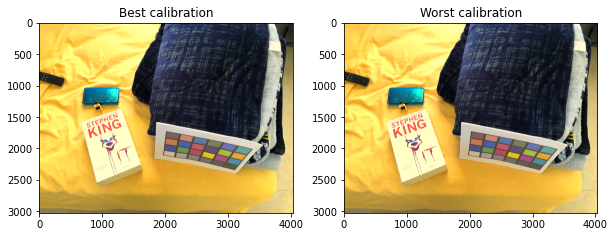

In [26]:
# Calibrar imagen.
best_calibrated_img = color_calibration(image_to_calibrate.copy(), best_m)
worst_calibrated_img = color_calibration(image_to_calibrate.copy(), worst_m)

# Mostrar imagen.
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(best_calibrated_img)
plt.title("Best calibration")
plt.subplot(1,2,2)
plt.imshow(worst_calibrated_img)
plt.title("Worst calibration")
plt.show()

### Results

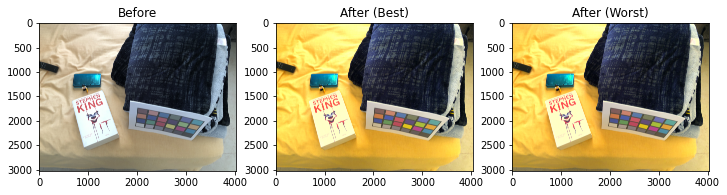

In [28]:
# Comparación entre la imagen antes de calibrar y la imagen calibrada, diferencias mìnimas pero notorias.
plt.figure(figsize=(12,10))
plt.subplot(1,3,1)
plt.title('Before')
plt.imshow(image_to_calibrate)
plt.subplot(1,3,2)
plt.title('After (Best)')
plt.imshow(best_calibrated_img)
plt.subplot(1,3,3)
plt.title('After (Worst)')
plt.imshow(worst_calibrated_img)
plt.show()

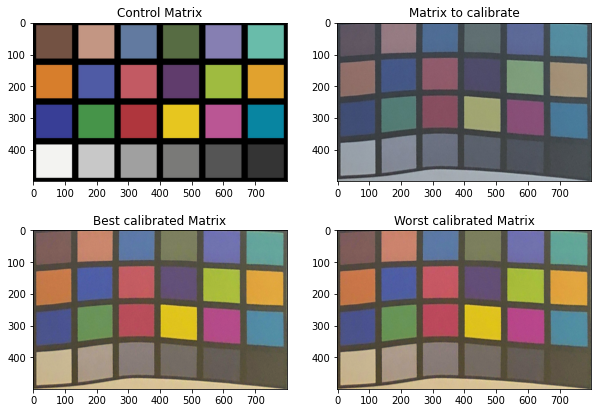

In [30]:
# Recortar matriz calibrada.
best_calibrated_matrix = cutMatrix(best_calibrated_img)
worst_calibrated_matrix = cutMatrix(worst_calibrated_img)

plt.figure(figsize=(10,7))
plt.subplot(2,2,1)
plt.title('Control Matrix')
plt.imshow(control_matrix_img)
plt.subplot(2,2,2)
plt.title('Matrix to calibrate')
plt.imshow(matrix_to_calibrate)
plt.subplot(2,2,3)
plt.title('Best calibrated Matrix')
plt.imshow(best_calibrated_matrix)
plt.subplot(2,2,4)
plt.title('Worst calibrated Matrix')
plt.imshow(worst_calibrated_matrix)
plt.show()

### Plot

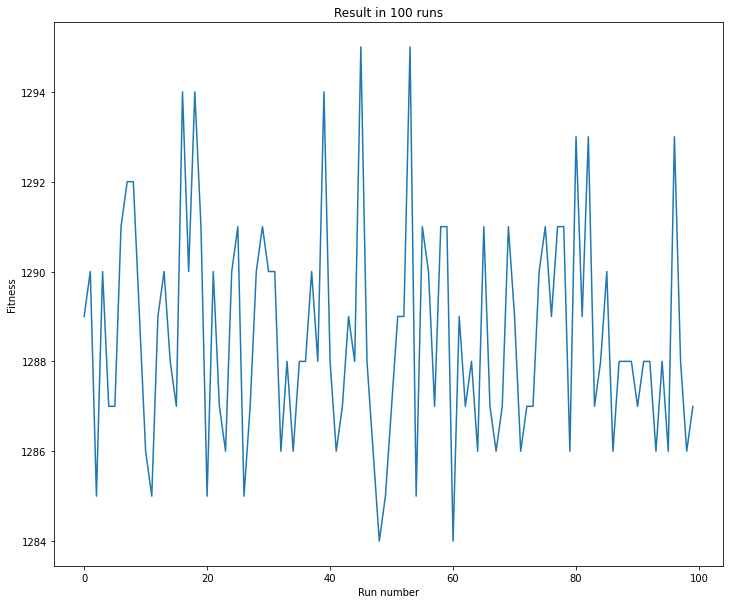

In [25]:
plt.figure(figsize=(12,10))
plt.plot(fitness_list)
plt.title('Result in 100 runs')
plt.xlabel('Run number')
plt.ylabel('Fitness')
plt.show()

### Metrics

In [22]:
print('Mean: ' + str(np.mean(fitness_list)))
print('Median: ' + str(np.median(fitness_list)))
print('Standard Deviation: ' + str(np.std(fitness_list)))

Mean: 1288.57
Median: 1288.0
Standard Deviation: 2.4667995459704466
